In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

## PyMC3 primer

In [3]:
np.random.seed(123)
trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0])

In [4]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)
    idata = pm.sample(1000, random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


### Summarizing the posterior

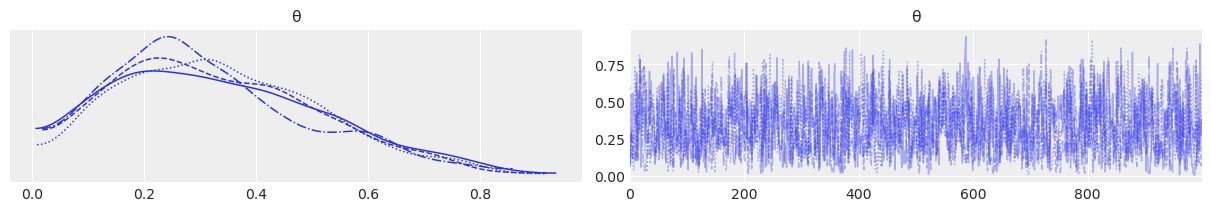

In [5]:
az.plot_trace(idata)
plt.savefig('B11197_02_01.png')

In [6]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.332,0.18,0.016,0.65,0.005,0.003,1418.0,1928.0,1.0


#### Posterior-based decisions

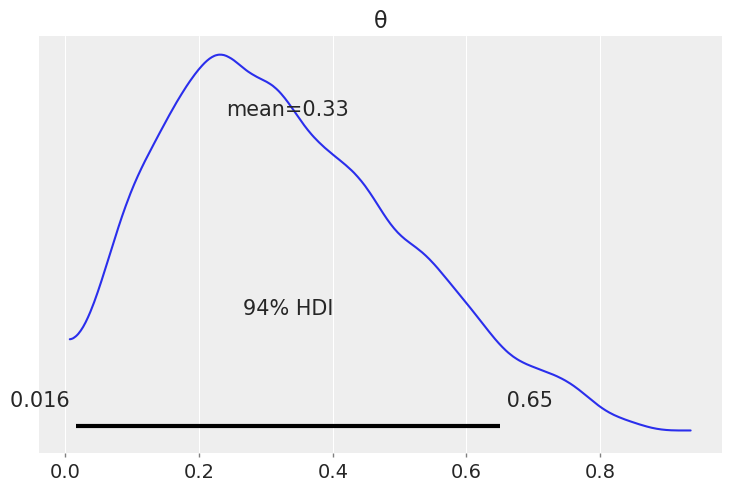

In [7]:
az.plot_posterior(idata)
plt.savefig('B11197_02_02.png', dpi=300)

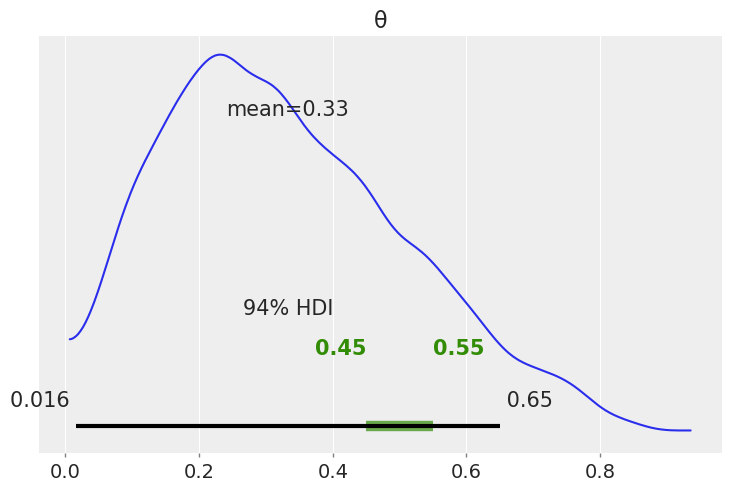

In [8]:
az.plot_posterior(idata, rope=[0.45, .55])
plt.savefig('B11197_02_03.png', dpi=300)

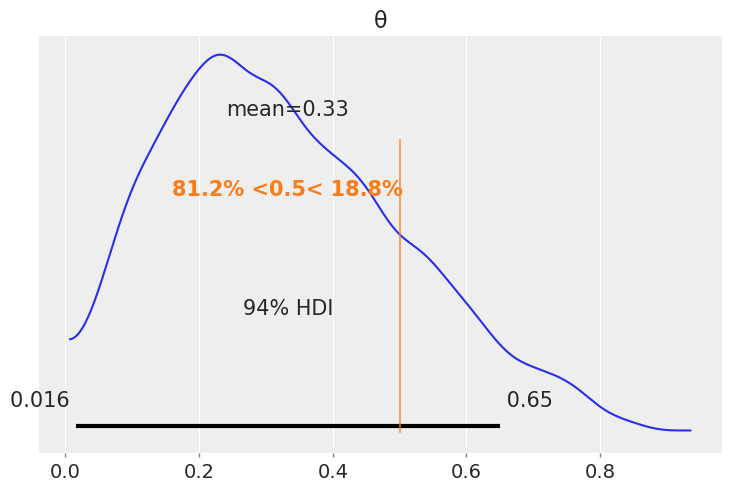

In [9]:
az.plot_posterior(idata, ref_val=0.5)
plt.savefig('B11197_02_04.png', dpi=300)

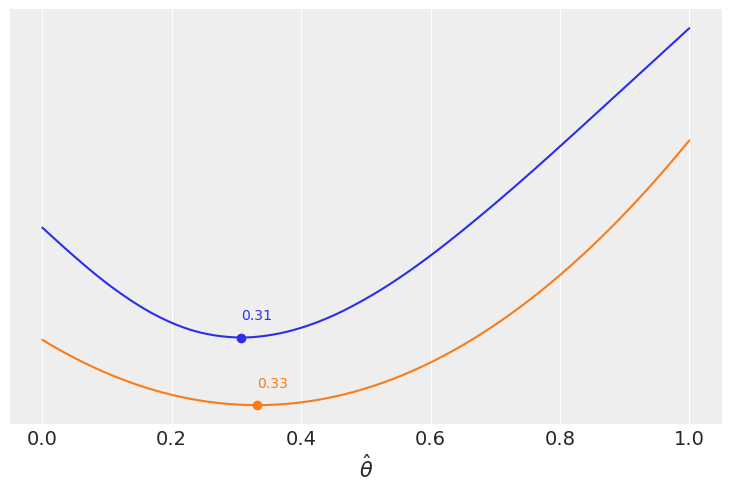

In [10]:
grid = np.linspace(0, 1, 200)
θ_pos = idata.posterior['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_05.png', dpi=300)

In [11]:
np.mean(θ_pos).item(), np.median(θ_pos)

(0.3318337027732896, 0.30799294354430506)

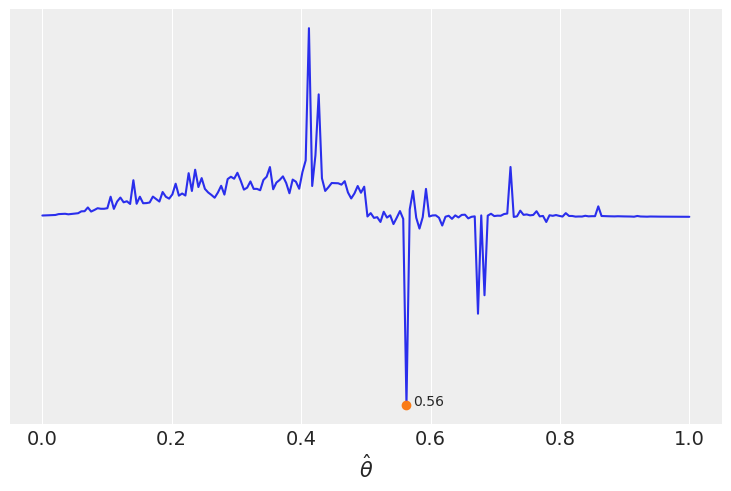

In [12]:
lossf = []
for i in grid:
    if i < 0.5:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]),
             (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$')
plt.savefig('B11197_02_06.png', dpi=300)

## Gaussian inferences

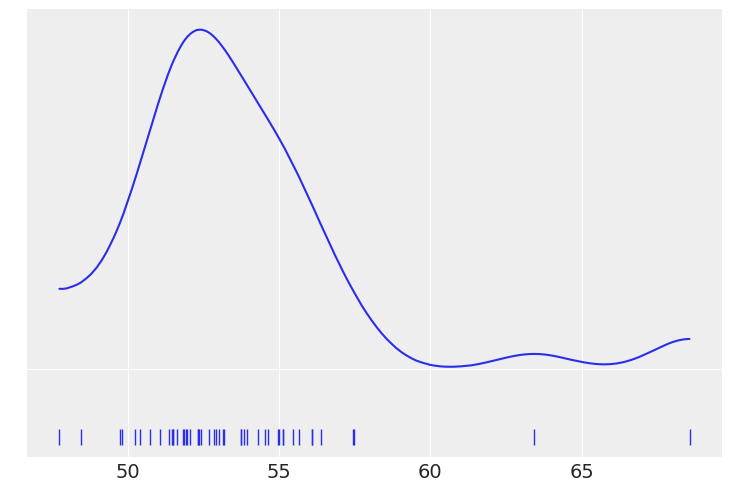

In [13]:
data = np.loadtxt('../data/chemical_shifts.csv')

# remove outliers using the interquartile rule
#quant = np.percentile(data, [25, 75])
#iqr = quant[1] - quant[0]
#upper_b = quant[1] + iqr * 1.5
#lower_b = quant[0] - iqr * 1.5
#data = data[(data > lower_b) & (data < upper_b)]
#print(np.mean(data), np.std(data))

az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)
plt.savefig('B11197_02_07.png', dpi=300)

 <img src="B11197_02_08.png" width="500">

In [14]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    idata_g = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


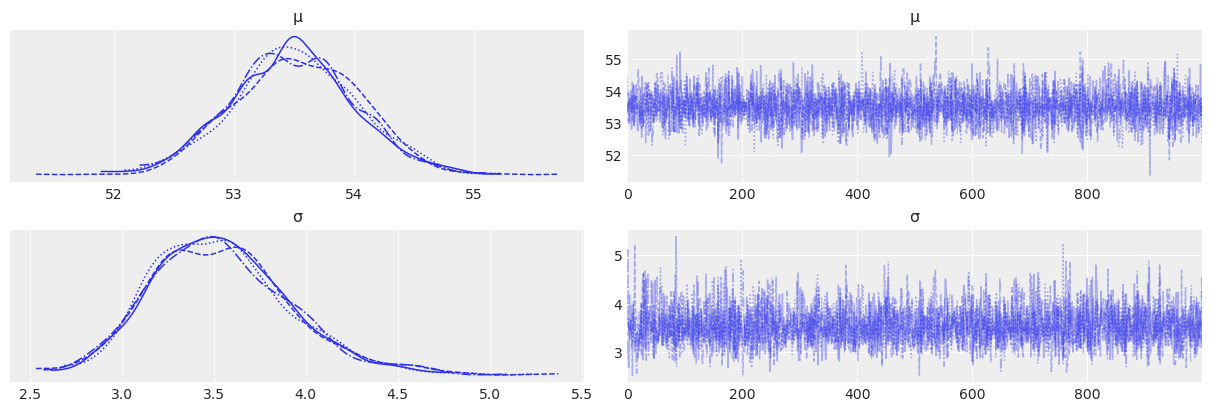

In [15]:
az.plot_trace(idata_g)
plt.savefig('B11197_02_09.png', dpi=300)

C:\Users\MSA\anaconda3\envs\pm3bap\lib\site-packages\arviz\plots\jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


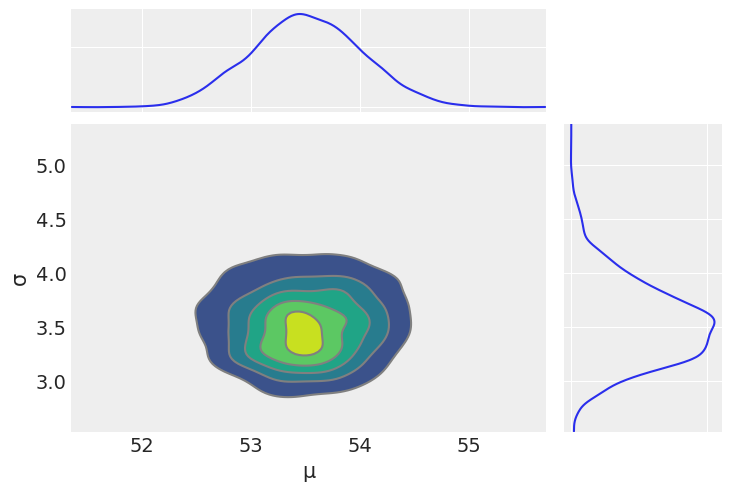

In [23]:
az.plot_joint(idata_g, kind='kde', fill_last=False)
plt.savefig('B11197_02_10.png', dpi=300)

In [17]:
az.summary(idata_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.508,0.514,52.561,54.483,0.009,0.006,3562.0,2801.0,1.0
σ,3.538,0.379,2.845,4.225,0.006,0.004,3591.0,2866.0,1.0


In [18]:
y_pred_g = pm.sample_posterior_predictive(idata_g, model=model_g, keep_size=True)

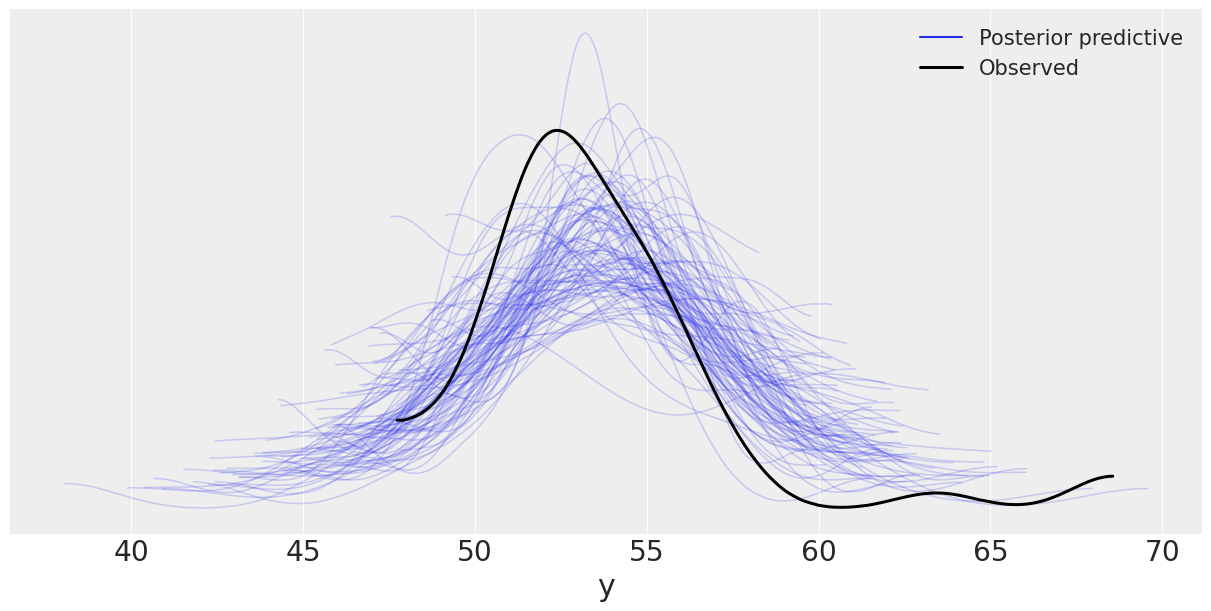

In [19]:
az.concat(idata_g, az.from_dict(posterior_predictive=y_pred_g), inplace=True)
ax = az.plot_ppc(idata_g, num_pp_samples=100, figsize=(12, 6), mean=False)
plt.savefig('B11197_02_11.png', dpi=300)

### Robust inferences

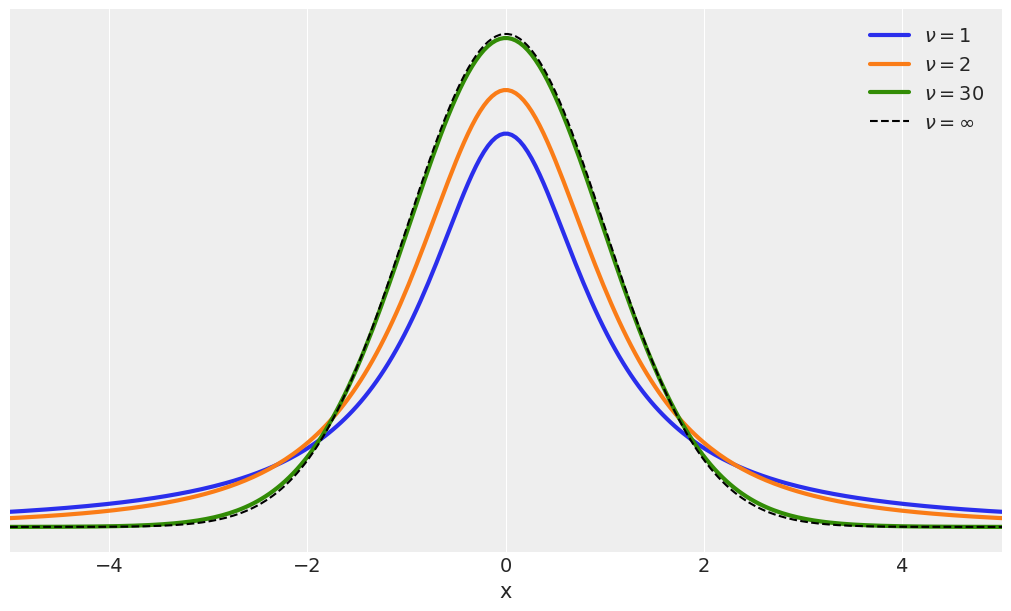

In [20]:
plt.figure(figsize=(10, 6))
x_values = np.linspace(-10, 10, 500)
for df in [1, 2, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {df}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)
plt.savefig('B11197_02_12.png', dpi=300)

 <img src="B11197_02_13.png" width="500">

In [24]:
with pm.Model() as model_t:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    idata_t = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


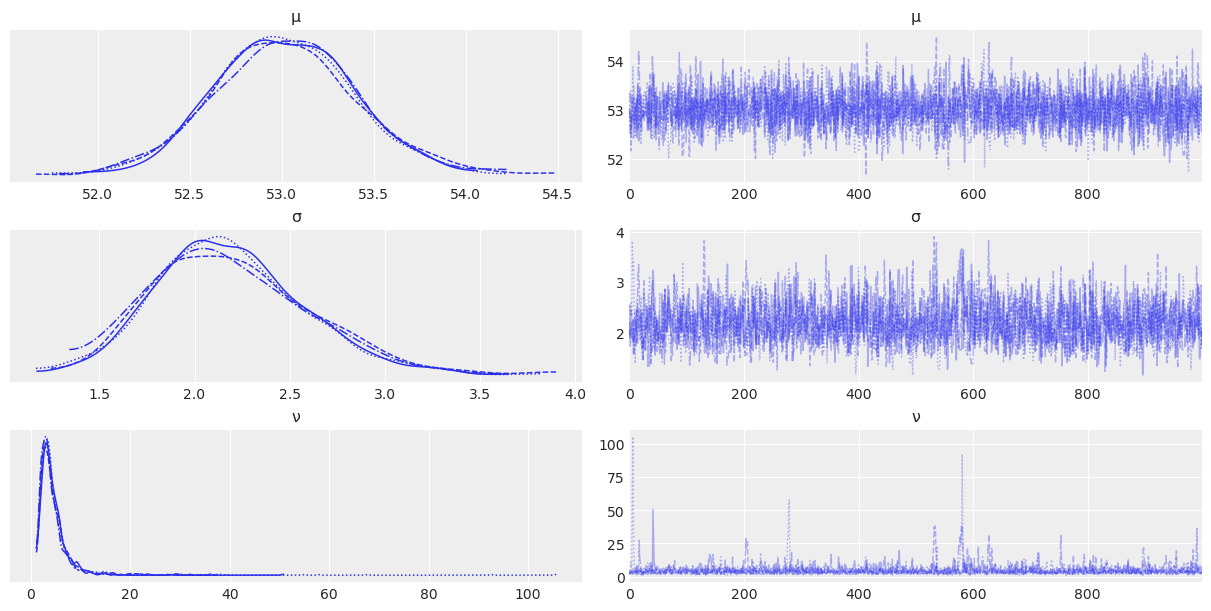

In [25]:
az.plot_trace(idata_t)
plt.savefig('B11197_02_14.png', dpi=300)

In [26]:
az.summary(idata_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.017,0.379,52.320,53.755,0.008,0.005,2532.0,2408.0,1.0
σ,2.187,0.404,1.498,2.997,0.010,0.007,1803.0,2196.0,1.0
ν,4.583,4.324,1.185,9.065,0.127,0.090,1624.0,1481.0,1.0


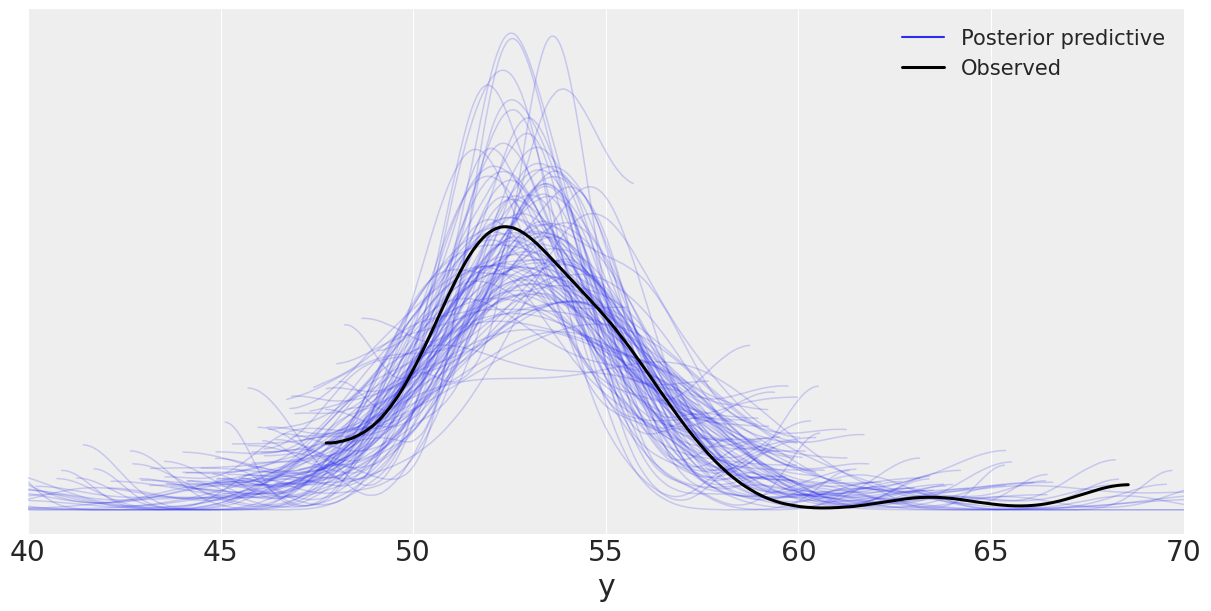

In [27]:
y_ppc_t = pm.sample_posterior_predictive(
    idata_t, model=model_t, random_seed=123, keep_size=True)
az.concat(idata_t, az.from_dict(posterior_predictive=y_ppc_t), inplace=True)
az.plot_ppc(idata_t, figsize=(12, 6), mean=False, num_pp_samples=100)
plt.xlim(40, 70)
plt.savefig('B11197_02_15.png', dpi=300)

# Tips example

In [42]:
tips = pd.read_csv('../data/tips.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


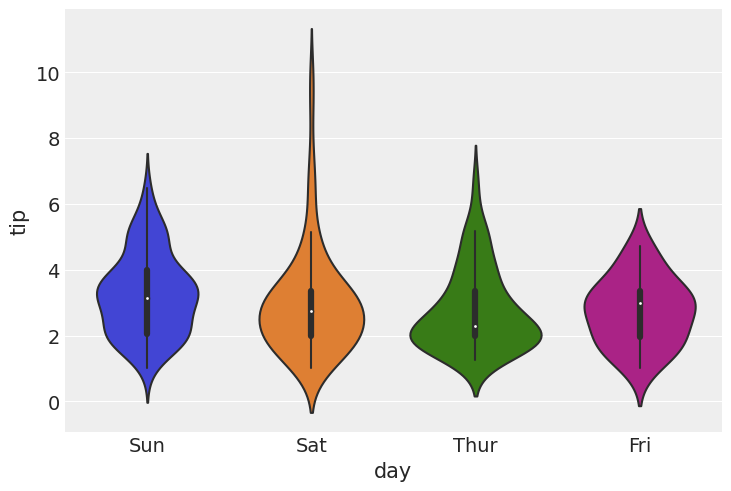

In [43]:
sns.violinplot(x='day', y='tip', data=tips)
plt.savefig('B11197_02_16.png', dpi=300)

In [30]:
tip = tips['tip'].values
idx = pd.Categorical(tips['day'],
                     categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 44 seconds.


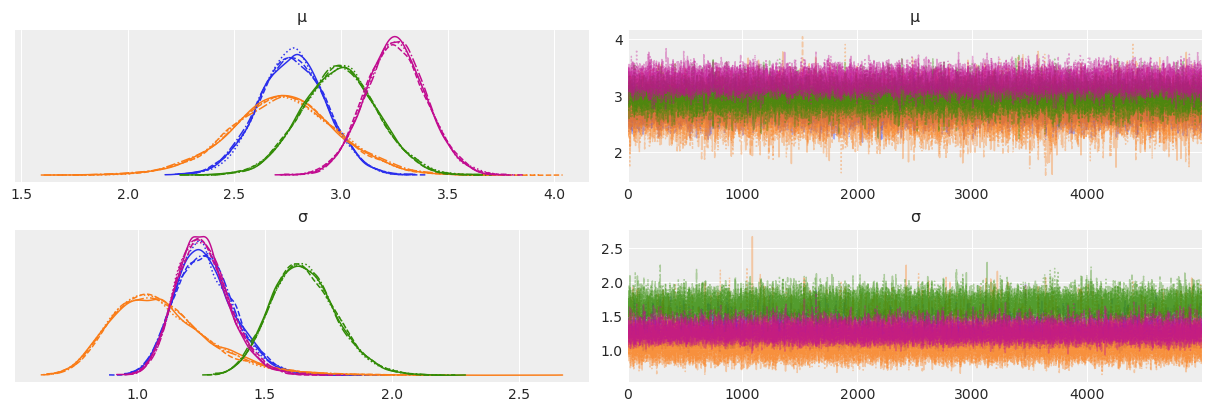

In [31]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    idata_cg = pm.sample(5000, return_inferencedata=True)
az.plot_trace(idata_cg)
plt.savefig('B11197_02_17.png', dpi=300)

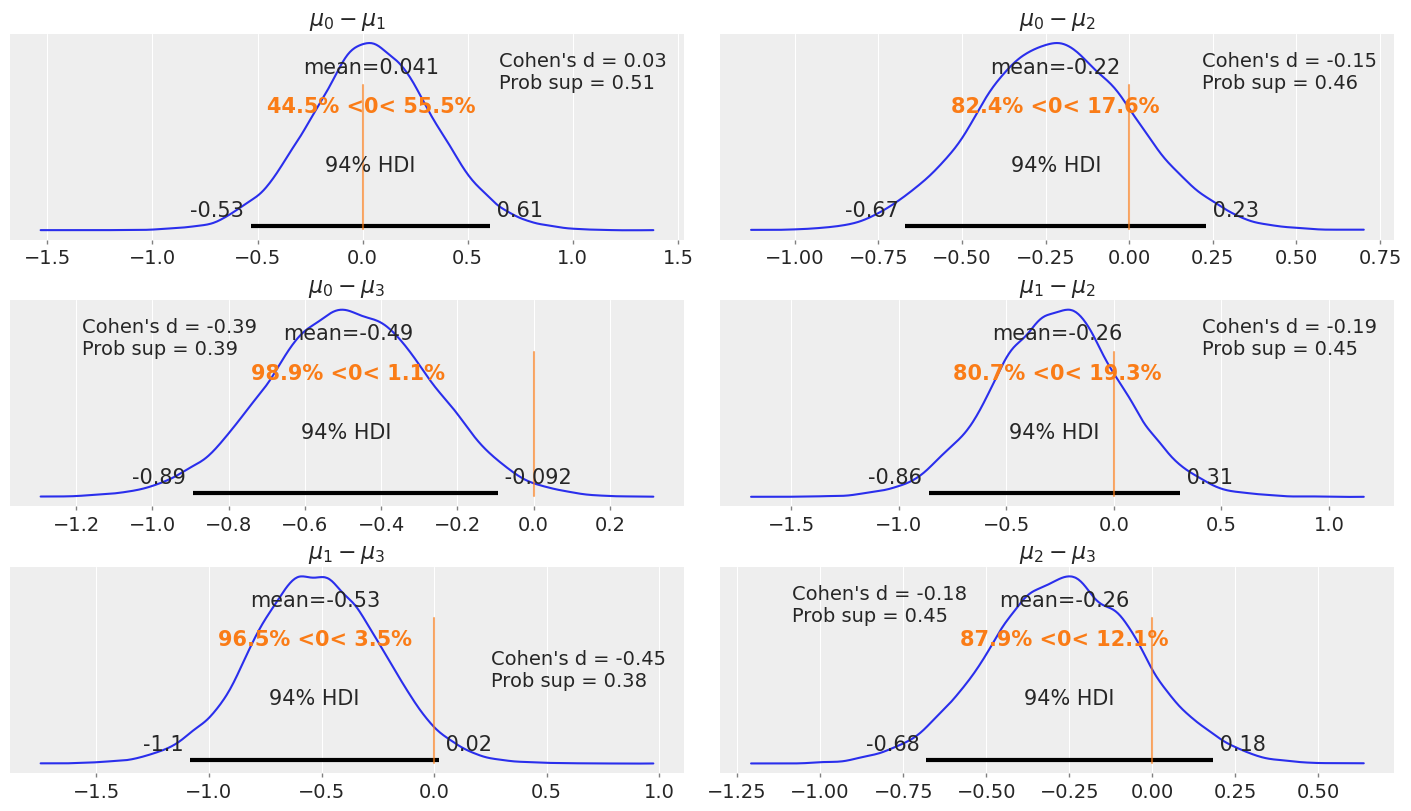

In [32]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(14, 8), constrained_layout=True)

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

posterior_cg = idata_cg.posterior.stack(samples={"chain", "draw"})

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = posterior_cg["μ"].sel({"μ_dim_0":i}) - posterior_cg["μ"].sel({"μ_dim_0":j})
    d_cohen = (means_diff / np.sqrt((posterior_cg["σ"].sel({"σ_dim_0":i})**2 + 
                                     posterior_cg["σ"].sel({"σ_dim_0":j})**2) / 2)).mean().item()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend()
plt.savefig('B11197_02_18.png', dpi=300)

# Hierarchical Models

 <img src="B11197_02_19.png" width="500">

In [33]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]  # [3, 3, 3]  [18, 3, 3]

group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [34]:
with pm.Model() as model_h:
    μ = pm.Beta('μ', 1., 1.)
    κ = pm.HalfNormal('κ', 10)

    θ = pm.Beta('θ', alpha=μ*κ, beta=(1.0-μ)*κ, shape=len(N_samples))
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    idata_h = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ, κ, μ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


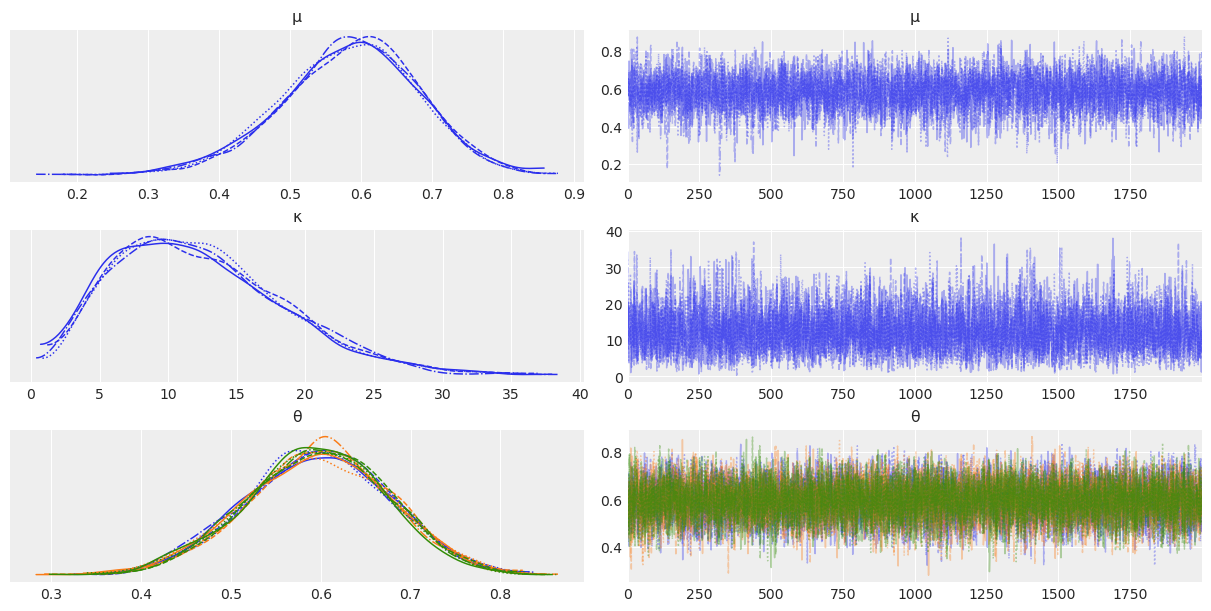

In [35]:
az.plot_trace(idata_h)
plt.savefig('B11197_02_20.png', dpi=300)

In [36]:
az.summary(idata_h)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,0.584,0.097,0.396,0.762,0.001,0.001,5107.0,4836.0,1.0
κ,12.306,6.178,1.715,23.372,0.080,0.057,5239.0,4550.0,1.0
θ[0],0.596,0.080,0.444,0.742,0.001,0.001,5832.0,5643.0,1.0
θ[1],0.597,0.081,0.445,0.749,0.001,0.001,6677.0,5841.0,1.0
θ[2],0.596,0.078,0.439,0.732,0.001,0.001,6193.0,5259.0,1.0


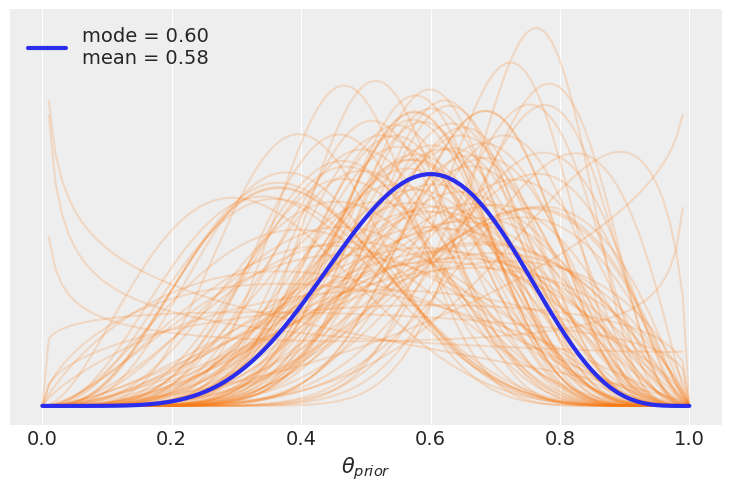

In [37]:
x = np.linspace(0, 1, 100)
posterior_h = idata_h.posterior.stack(samples={"chain", "draw"})

for i in np.random.randint(0, posterior_h.samples.size, size=100):
    u = posterior_h['μ'][i]
    k = posterior_h['κ'][i]
    pdf = stats.beta(u*k, (1.0-u)*k).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

u_mean = posterior_h['μ'].mean().item()
k_mean = posterior_h['κ'].mean().item()
dist = stats.beta(u_mean*k_mean, (1.0-u_mean)*k_mean)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, lw=3, label=f'mode = {mode:.2f}\nmean = {mean:.2f}')
plt.yticks([])

plt.legend()
plt.xlabel('$θ_{prior}$')
plt.tight_layout()
plt.savefig('B11197_02_21.png', dpi=300)

In [38]:
cs_data = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo.values - cs_data.exp.values
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

In [39]:
with pm.Model() as cs_nh:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    idata_cs_nh = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [40]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_μ = pm.Normal('μ_μ', mu=0, sd=10)
    σ_μ = pm.HalfNormal('σ_μ', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_μ, sd=σ_μ, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff)

    idata_cs_h = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ, σ_μ, μ_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


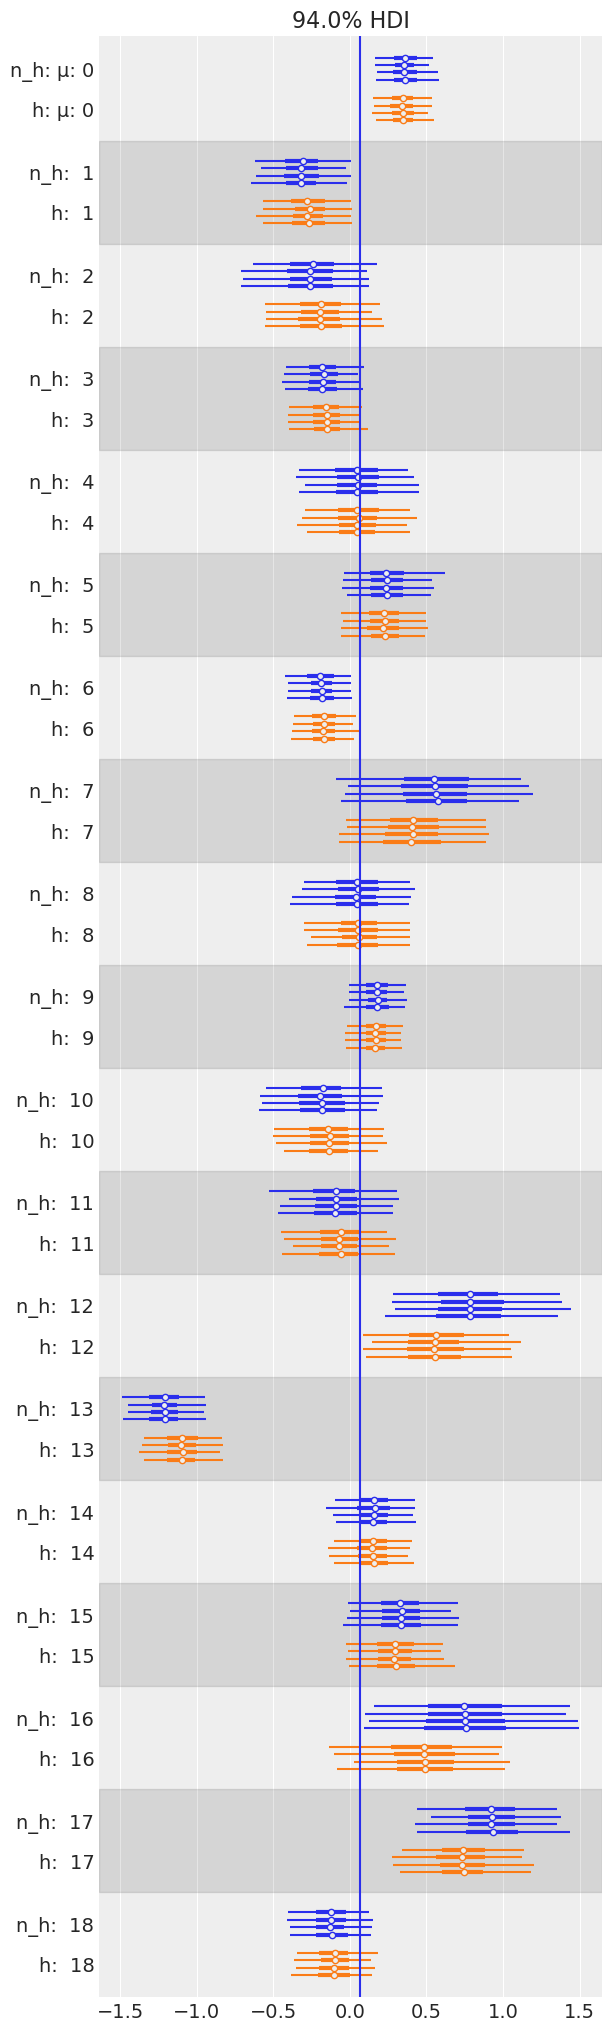

In [41]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h],
                         model_names=['n_h', 'h'],
                         var_names='μ', combined=False, colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_μ'].mean(), *y_lims)
plt.savefig('B11197_02_22.png', dpi=300)